In [1]:
import molgrid
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
import os
import matplotlib.pyplot as plt

In [2]:
# set some constants
batch_size = 50
datadir = os.getcwd() +'/data'
fname = datadir+"/small.types"

molgrid.set_random_seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# define network architecture
class Net(nn.Module):
    def __init__(self, dims):
        super(Net, self).__init__()
        self.pool0 = nn.MaxPool3d(2)
        self.conv1 = nn.Conv3d(dims[0], 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)

        self.last_layer_size = dims[1]//8 * dims[2]//8 * dims[3]//8 * 128
        self.fc1 = nn.Linear(self.last_layer_size, 2)

    def forward(self, x):
        x = self.pool0(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.last_layer_size)
        x = self.fc1(x)
        return x

In [4]:
# define weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

In [5]:
# use the libmolgrid ExampleProvider to obtain shuffled, balanced, and stratified batches from a file
e = molgrid.ExampleProvider(data_root=datadir+"/structs",balanced=True,shuffle=True)
e.populate(fname)

In [6]:
# initialize libmolgrid GridMaker
gmaker = molgrid.GridMaker()
dims = gmaker.grid_dimensions(e.num_types())
tensor_shape = (batch_size,)+dims

In [7]:
# initialize Net on GPU
model = Net(dims).to('cuda')
model.apply(weights_init)

Net(
  (pool0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(28, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=27648, out_features=2, bias=True)
)

In [8]:
# construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
# construct input tensors
input_tensor = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
float_labels = torch.zeros(batch_size, dtype=torch.float32)

In [10]:
# train for 500 iterations
losses = []
for iteration in range(500):
    # load data
    batch = e.next_batch(batch_size)
    # libmolgrid can interoperate directly with Torch tensors, using views over the same memory.
    # internally, the libmolgrid GridMaker can use libmolgrid Transforms to apply random rotations and translations for data augmentation
    # the user may also use libmolgrid Transforms directly in python
    gmaker.forward(batch, input_tensor, 0, random_rotation=False)
    batch.extract_label(0, float_labels)
    labels = float_labels.long().to('cuda')

    optimizer.zero_grad()
    output = model(input_tensor)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optimizer.step()
    losses.append(float(loss))

In [11]:
%matplotlib inline

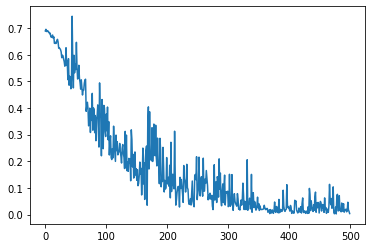

In [12]:
plt.plot(losses)